# 常微分方程式の周期解の数値計算

$\newcommand{\im}{\mathrm{i}}$
常微分方程式の一つであるvan der Pol方程式の周期解の数値計算をまず行い、得た近似解をもとに解の精度保証の方法を紹介する。

### van der Pol 方程式
van der Pol方程式とは、以下のような方程式である。

$$
\frac{d^2 x}{dt^2} - \mu (1-x^2)\frac{dx}{dt} + x = 0.
$$

$x(t)$ が未知関数で、$\mu>0$ は非線形の減衰の強さを表すパラメータである。van der Pol方程式をJulia言語の`DifferentialEquations.jl`というパッケージを使って解の挙動を数値計算する。

van der Pol 方程式を次の連立常微分方程式系にして`DifferentialEquations.jl`のODEソルバーで数値計算する。

$$
\begin{cases}
\dot{x} = y\\
\dot{y} = \mu (1-x^2)y - x
\end{cases}
$$

<!-- ここで、周期解を求めてみよう。

$x(t)$を周期$L$の周期関数とすると、$\omega = \frac{2\pi}{L}$として、

$$
x(t) = \sum_{k \in \mathbb{Z}} a_k e^{\im k\omega t} \\
\frac{dx(t)}{dt} = \sum_{k \in \mathbb{Z}}(\im k \omega) a_k e^{\im k \omega t} \\
\frac{d^2 x(t)}{dt^2} = \sum_{k \in \mathbb{Z}} (-  k^2 \omega^2 )a_k e^{\im k\omega t} \\
x(t)^2 = \sum_{k \in \mathbb{Z}} (a * a)_k e^{\im k \omega t}
$$
 -->

In [1]:
using DifferentialEquations

function vanderpol(du, u , μ ,t)
    x,y = u
    du[1] = y
    du[2] = μ*(1- x ^2)*y - x
end

vanderpol (generic function with 1 method)

初期値 $x(0)=0$, $y(0)=2$とし, $\mu=1$ のときの数値計算は以下のように実行できる。

In [2]:
u₀ = [0.0; 2.0]
tspan = (0.0, 100)
μ = 1.0
prob = ODEProblem(vanderpol, u₀, tspan, μ)
sol = solve(prob,Tsit5(),reltol=1e-8,abstol=1e-8)

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 2044-element Vector{Float64}:
   0.0
   0.009232541136674264
   0.025038490508251625
   0.04358791899991135
   0.06644522765433977
   0.09233091009839688
   0.12139889326064038
   0.1527798720803449
   0.18598701552799873
   0.22027028414650623
   0.25511905978215
   0.2901157405147314
   0.32502613973418404
   ⋮
  99.27213753323024
  99.35743637491996
  99.44344770133299
  99.52381518597751
  99.59923309896803
  99.6697938246669
  99.73619386954825
  99.79881766987441
  99.85804395400453
  99.91404185266292
  99.96694642728168
 100.0
u: 2044-element Vector{Vector{Float64}}:
 [0.0, 2.0]
 [0.018550316575803645, 2.0184626866340247]
 [0.05070360278450727, 2.050027995323544]
 [0.08907288489089711, 2.0869098311266012]
 [0.13728953636802385, 2.1319144283572338]
 [0.19312567108124173, 2.181938372204465]
 [0.2573462129757005, 2.236335531660329]
 [0.3284087534471016, 2.2920864146719477]
 [0.40544115304345646, 2.346530

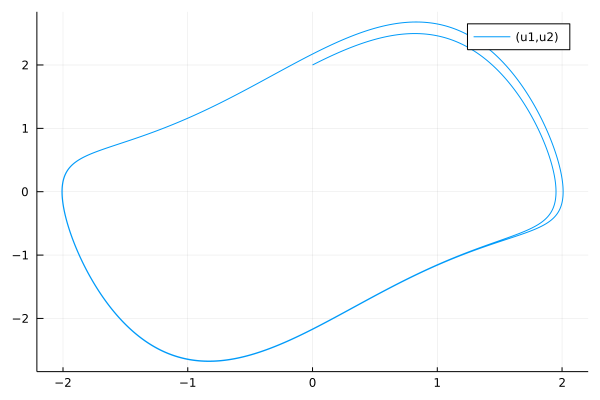

In [4]:
using Plots
plot(sol,vars=(1,2))

In [5]:
u = hcat(sol.u...)

2×2044 Matrix{Float64}:
 0.0  0.0185503  0.0507036  0.0890729  …  0.00787276  0.126265  0.203269
 2.0  2.01846    2.05003    2.08691       2.18057     2.29477   2.36421

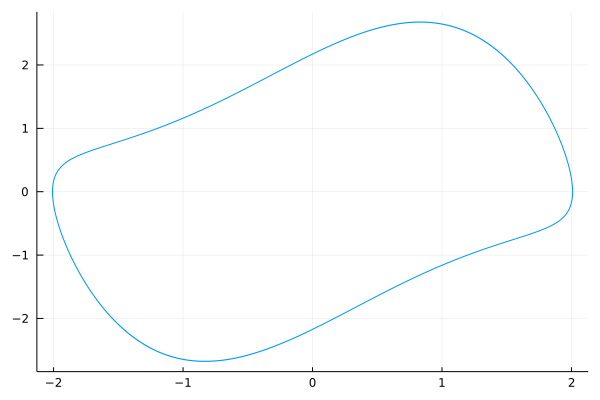

In [6]:
ind = floor(Int, length(sol.t)/2)
plot(u[1, ind:end], u[2, ind:end], legend=false)

### Newton法の初期値の設定

#memo

#fourier係数を求める

#step1. 周期解の周期を求める
#step2. fouriercoeffsの関数をvan der Pol用に作り変える
#step3. solをfouriercoeffsに代入して係数を求める

In [7]:
#おおよその周期
# a = 30
# b = 36.55
a = 30
app_period = 6.55
timestep = 0.1

f_tmp = sol(a+app_period/2:timestep:a+3*app_period/2)
find_period = abs.(f_tmp .- sol(a))
(~,ind) = findmin(find_period[1,:])
b = a+app_period/2 + timestep*(ind-1)
# abs.(sol(b) .- sol(a))

36.675

In [8]:
#a function of  fourier coeffs (lecture7参照)
using FFTW
function odefouriercoeffs(f, I, N, n)
    a = I[1]; b = I[2];
    # x_j: equidistance node points
    h = (b-a)/(2N-1)
    j = 0:2N-2
    xⱼ = a .+ j*h
    # f_j: function values on node points
    fⱼ = f(xⱼ)[n,:]
    return (fftshift(fft(fⱼ)))/(2*N+1)
end

odefouriercoeffs (generic function with 1 method)

In [9]:
#calc fouriercoeffs
N = 61
x = odefouriercoeffs(sol,[a,b],N,1)

121-element Vector{ComplexF64}:
 0.00010680702634784247 + 1.4237801934823843e-6im
 0.00010680315127110992 + 4.273089180717703e-6im
  0.0001067955378742854 + 7.128394355433009e-6im
  0.0001067838070251457 + 9.993204502034595e-6im
 0.00010676848347840013 + 1.2871758929974086e-5im
 0.00010674873349033196 + 1.576791713149531e-5im
 0.00010672523919202198 + 1.8685714681490683e-5im
 0.00010669712060836266 + 2.1629613818999032e-5im
  0.0001066647218561076 + 2.4603704774679387e-5im
 0.00010662763040798275 + 2.761285140357246e-5im
 0.00010658560106817831 + 3.0661585724011085e-5im
 0.00010653864257541877 + 3.375503283424912e-5im
 0.00010648609464189038 + 3.689833390516544e-5im
                        ⋮
 0.00010653864257541852 - 3.375503283424861e-5im
 0.00010658560106817868 - 3.0661585724010767e-5im
   0.000106627630407983 - 2.76128514035727e-5im
 0.00010666472185610491 - 2.4603704774680535e-5im
 0.00010669712060836266 - 2.1629613818999046e-5im
 0.00010672523919201029 - 1.8685714681538198e-5im
 0

In [10]:
#x:x, y : \dot{x}のグラフを作りたい
#\dot{x}の求め方
function plot_solution(u, index) # u = [ω, a_{-N+1}, ..., a_0, ..., a_{N-1}], length(u) = 2N
    # index = 1: profile of solution
    #         2: Fourier mode
    #         3: phase profile
    L = 2π/real(u[1])
    a = u[2:end]
    m = length(u)/2 # m: size of Fourier
    m_pad = 1000
    a_pad = [zeros(m_pad);a;zeros(m_pad)]
    N = m-1 # maximal wave number
    N_pad = m+m_pad-1
    k = -N_pad:N_pad
    dx = L/(2*N_pad-1)
    x = dx*(0:2*N_pad)
    if index == 1
    # Plot profile:
        plot(x,real((2*N_pad+1)*ifft(ifftshift(a_pad))),
            xlabel = "\$t\$",
            ylabel = "\$x\\,(t)\$",
            line   = 1.6,
            title  = "Profile of solution",
            size   = (720,400),
            legend = false,
        )
    elseif index == 2
    # Plot Fourier coefficients:
        plot(-N:N,abs.(a),yscale=:log10,
            xlabel = "\$k\$",
            ylabel = "\$|a_k\\,|\$",
            line   = 1.6,
            title  = "Fourier coefficients of solution",
            size   = (720,400),
            legend = false,
        )
    elseif index == 3
    # Plot phase:
      plot(real((2*N_pad+1)*ifft(ifftshift(a_pad))),real((2*N_pad+1)*ifft(ifftshift(a_pad.*(im*k)))),
            xlabel = "\$x(t)\$",
            ylabel = "\$\\dot{x}\\,(t)\$",
            line   = 1.6,
            title  = "Phase plot of a numerical solution",
            size   = (720,400),
            legend = false,
        )
    end
end
function plot_solution!(u)
    L = 2π/real(u[1])
    a = u[2:end]
    m = length(u)/2
    m_pad = 1000
    a_pad = [zeros(m_pad);a;zeros(m_pad)]
    N = m-1
    N_pad = m+m_pad-1
    k = -N_pad:N_pad
    dx = L/(2*N_pad-1)
    x = dx*(0:2*N_pad)
    plot!(real((2*N_pad+1)*ifft(ifftshift(a_pad))),real((2*N_pad+1)*ifft(ifftshift(a_pad.*(im*k)))),line=1.6,)
end

plot_solution! (generic function with 1 method)

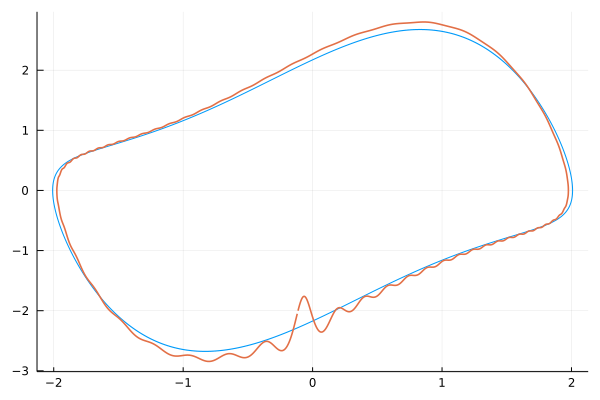

In [11]:
x0 = [2*pi/(b-a);x]
plot_solution!(x0)

### Newton法を用いて周期解を数値計算する

van der Pol方程式は、$\dot{x} = \frac{dx}{dt}$とおくと、以下のように表すことができる。

$$
\ddot{x} - \mu(1-x^2)\dot{x} + x = 0
$$

後の計算のために、式を少し整理すると、

$$
\ddot{x} - \mu\dot{x} + \frac{\mu}{3} \dot{(x^3)} + x = 0
$$

と書ける。

また、周期解$x(t)$を周期$L$の周期関数とし、$\omega = \frac{2\pi}{L}$とおくと、$x(t)$とその微分や$2$乗はフーリエ級数を使って、

\begin{align*}
x(t) &= \sum_{k \in \mathbb{Z}} a_k e^{\im k\omega t} \\
\frac{dx(t)}{dt} &= \sum_{k \in \mathbb{Z}}(\im k \omega) a_k e^{\im k \omega t} \\
\frac{d^2 x(t)}{dt^2} &= \sum_{k \in \mathbb{Z}} (-  k^2 \omega^2 )a_k e^{\im k\omega t} \\
x(t)^3 &= \sum_{k \in \mathbb{Z}} (a * a * a)_k e^{\im k \omega t}
\end{align*}

と書くことができる。



以上の式を用いて、フーリエ係数に関する式を立てる。$a = (a_k) \quad k \in \mathbb{Z}$に対して、van der Pol方程式に求めたフーリエ級数を代入すると、

$$
f_k(a)  = -k^2\omega^2 a_k - \mu\im k \omega a_k + \frac{\mu }{3}(\im k \omega)(a*a*a)_k + a_k
$$

と書ける。そして、この式がvan der Pol方程式の解の係数になっているならば、

$$
f_k(a) = 0
$$

となる。

$$
 \bar{x}(t) = \sum_{|k|<N} \bar{a}_k e^{\im k \omega t}.
$$

$$
    \bar x = (\bar\omega, \bar{a}_{-N+1},\dots,\bar{a}_{N-1})\in \mathbb{C}^{2N}
$$

In [31]:
function powerconvfourier(a::Vector{Complex{T}},p) where T
    M = Int((length(a)+1)/2)
    N = (p-1)*M
    ta = [zeros(N,1);a;zeros(N,1)] # 1. Padding zeros: size(ta) = 2pM-1
    tb = ifft(ifftshift(ta)) # 2. IFFT of ta
    tbᵖ = tb.^p # 3. tb*^tb
    cᵖ = fftshift(fft(tbᵖ))*(2.0*p*M-1)^(p-1)
    return cᵖ[N+1:end-N], cᵖ[p:end-(p-1)]# return (truncated, full) version
end

powerconvfourier (generic function with 1 method)

In [65]:
function F_fourier(x, μ, η₀)
    N = length(x)/2
    ω = x[1]
    a = x[2:end]
    (a³,~) = powerconvfourier(a,3)
    eta = sum(a) - η₀

    k = -(N-1):(N-1)
    f = (- k.^2 * ω^2 - μ* im * k * ω .+ 1) .* a + μ*im * k *ω .* a³ / 3

    return [eta;f]
end

F_fourier (generic function with 1 method)

In [49]:
norm(F_fourier(x, μ, η₀),1)

22.250116985658952

## ヤコビ行列の計算式を書く

In [66]:
function DF_fourier(x, μ)
    N = Int((length(x)-2)/2)
    ω = x[1]
    a = x[2:end]
    k = -N:N
    (a³,~) = powerconvfourier(a,3)

    DF = zeros(ComplexF64,2*N+2,2*N+2)

    DF[1,2:end] .= 1
    DF[2:end,1] = (- 2*ω*k.^2 + μ*im*k) .* a + μ*im*k .*a³/3

    (~,a2) = powerconvfourier(a,2)
    
    M = zeros(ComplexF64,2*N+1, 2*N+1)

    for j=-N:N
        M[k.+(N+1), j+N+1] = μ*im*k*ω.*a2[k.-j.+(2*N+1)]
    end
    
    L = diagm(- k.^2 * ω^2 - μ* im * k * ω .+ 1)
    
    DF[2:end,2:end] = L + M
    return DF
end

DF_fourier (generic function with 1 method)

In [51]:
DF_fourier(x, μ)

122×122 Matrix{ComplexF64}:
       0.0+0.0im                1.0+0.0im         …          1.0+0.0im
 -0.721756-0.0224048im     -3188.77-168.839im         1.71772e-8-6.44173e-7im
  -0.69751-0.0404566im   -0.0600111+0.246615im        6.75838e-8-1.26638e-6im
 -0.676851-0.0525706im     -27.6636+42.283im          1.49569e-7-1.86615e-6im
 -0.653435-0.0684468im     0.145318-0.0242072im       2.61517e-7-2.44305e-6im
  -0.63002-0.0819523im      3.73618+11.0159im     …    4.0185e-7-2.99669e-6im
 -0.607436-0.0956681im    0.0449308-0.0865981im       5.69023e-7-3.52669e-6im
 -0.584934-0.108245im       2.81228+0.909066im        7.61516e-7-4.03269e-6im
 -0.563151-0.119948im   -0.00597313-0.0460897im       9.77843e-7-4.51439e-6im
 -0.541689-0.130757im      0.630669-0.454871im        1.21654e-6-4.97148e-6im
 -0.520697-0.140614im   -0.00726184-0.0151949im   …   1.47615e-6-5.4037e-6im
 -0.500099-0.149627im    0.00735803-0.209095im        1.75527e-6-5.8108e-6im
   -0.4799-0.157786im   -0.00063513-0.0054110

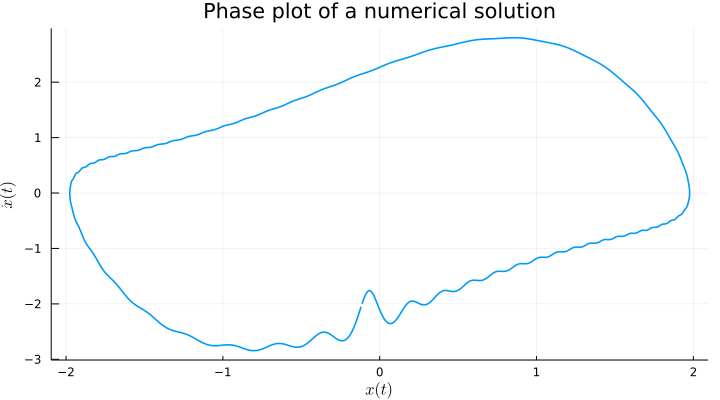

In [56]:
plot_solution(x0, 3)

Before step #1, ||F||_1 = 16.83369755300606
After step #1, ||F||_1 = 0.08542926424843804
After step #2, ||F||_1 = 0.003148542635442544
After step #3, ||F||_1 = 0.0008004767519457863
After step #4, ||F||_1 = 0.00022958024951624608
After step #5, ||F||_1 = 6.423579278855552e-5
After step #6, ||F||_1 = 1.810302162799183e-5
After step #7, ||F||_1 = 5.091535370338057e-6
After step #8, ||F||_1 = 1.4328262163287634e-6
After step #9, ||F||_1 = 4.031520598107707e-7
After step #10, ||F||_1 = 1.1343944544438456e-7
After step #11, ||F||_1 = 3.191938699937453e-8
After step #12, ||F||_1 = 8.981580702445537e-9
After step #13, ||F||_1 = 2.527349538615561e-9
After step #14, ||F||_1 = 7.112636790204328e-10
After step #15, ||F||_1 = 2.002511792569915e-10


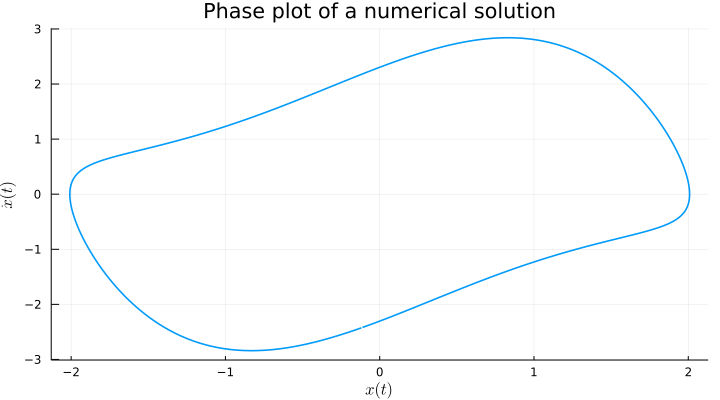

In [68]:
using LinearAlgebra
# Initial value of Newton method
η₀ = real(sum(x0[2:end]))
x = x0

# Newton iteration
tol = 5e-10
F = F_fourier(x, μ, η₀)
println("Before step #1, ||F||_1 = $(norm(F,1))")
num_itr = 0

while num_itr ≤ 100
    x = x - DF_fourier(x, μ)\F
    num_itr += 1
    F = F_fourier(x, μ, η₀)
    println("After step #$(num_itr), ||F||_1 = $(norm(F,1))")
    if norm(F,1) < tol
        break
    end
end

L = 2π/real(x[1])
plot_solution(x, 3)